If the variable depth relation is too big, then the multiplicative term is not negligible anymore

This notebook investigates this behaviour

In [1]:
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl 

In [2]:
from astropy.io import fits

def CreateGalaxyNumberDensityMap(file, mask, nside):
    ''' 
    Write a catalogue of galaxies with given right acension and declination to a healpy man that depicts the number density

    arguments:
        file: filename of the file containing the catalogue
        mask: healpy-map of the mask
        nside: desired nside of the number density map 
    '''
    
    catalogue = fits.open(file)[1].data

    RA = catalogue['ALPHA_J2000']
    DEC = catalogue['DELTA_J2000']
    
    pixind = hp.ang2pix(nside, RA, DEC, lonlat=True)
    npix = hp.nside2npix(nside)

    ## create map of galaxies
    galaxymap = np.bincount(pixind, minlength=npix)
    return galaxymap / np.mean(galaxymap[mask==1])


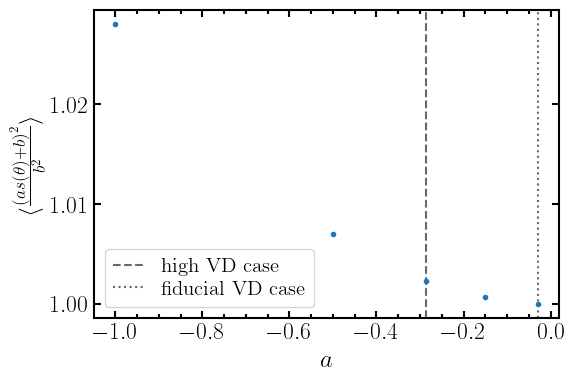

In [3]:
folder_list = ['1024_fiducial/', '1024_mp15/', '1024_high/', '1024_mp5/', '1024_m1/']
a_list = [-0.0287, -0.15, -0.287, -0.5, -1]
b = 0.94

temp = hp.ud_grade(hp.read_map('../templates/DECALS_DepthMap_fullsky.fits'), 1024)
mask = hp.ud_grade(hp.read_map('../templates/DECALS_mask.fits'), 1024)
temp[mask==0] = np.nan

nside = hp.get_nside(temp)
bedges = np.array([   2,    4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048, 3073])
bins = nmt.NmtBin.from_edges(bedges[:-1], bedges[1:])
ells = bins.get_effective_ells()

fig = plt.figure(figsize=(6,4))
grid = fig.add_gridspec(1,1, hspace=0)
ax1 = grid.subplots()

results = {}
mean_arr = []
for i, folder in enumerate(folder_list):
    path = f'/vol/aleph/data/mheld/salmo/SALMO_simulations/nonlinearbias/{folder}'

    a = a_list[i]
    rel = (a*temp + b) / b
    
    mean = np.nanmean(rel**2)
    mean_arr.append(mean)
    #results[f'mean a = {a}'] = mean
    ax1.scatter(a, mean, color='tab:blue', marker='.')

plt.axvline(-0.287, linestyle='--', color='dimgrey', zorder=0, label='high VD case')
plt.axvline(-0.0287, linestyle=':', color='dimgrey', zorder=0, label='fiducial VD case')
plt.legend()
#plt.loglog()
#ax1.set_yticks([0.6,0.7,0.8,0.9,1])
ax1.set_ylabel('$\\langle \\frac{(a s(\\theta) + b)^2}{b^2}\\rangle$')
ax1.set_xlabel('$a$')
plt.show()

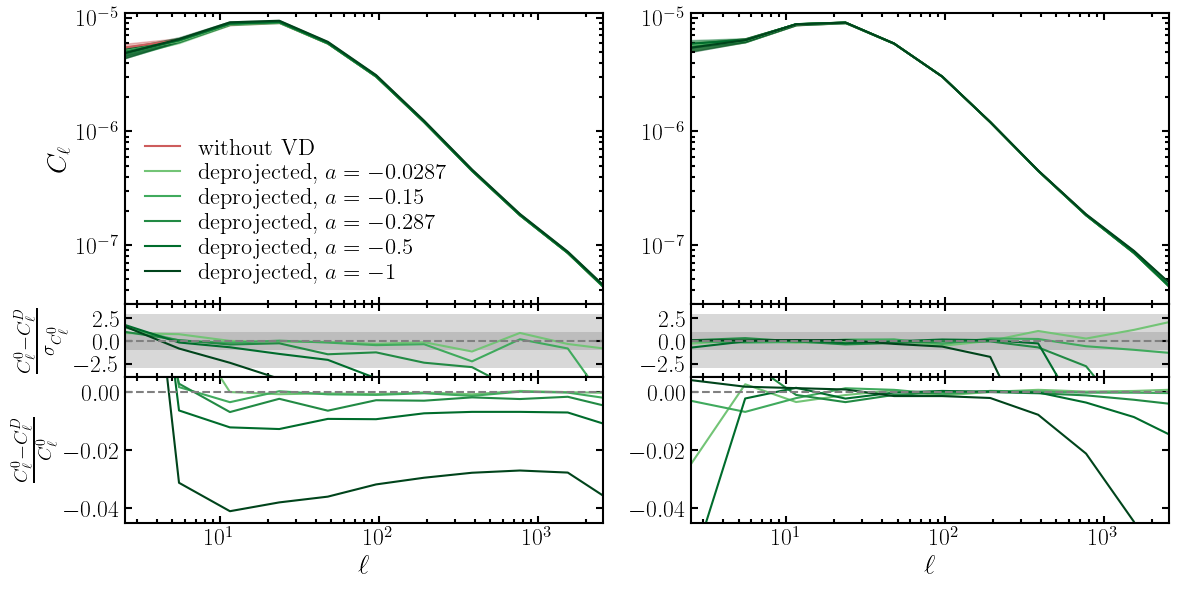

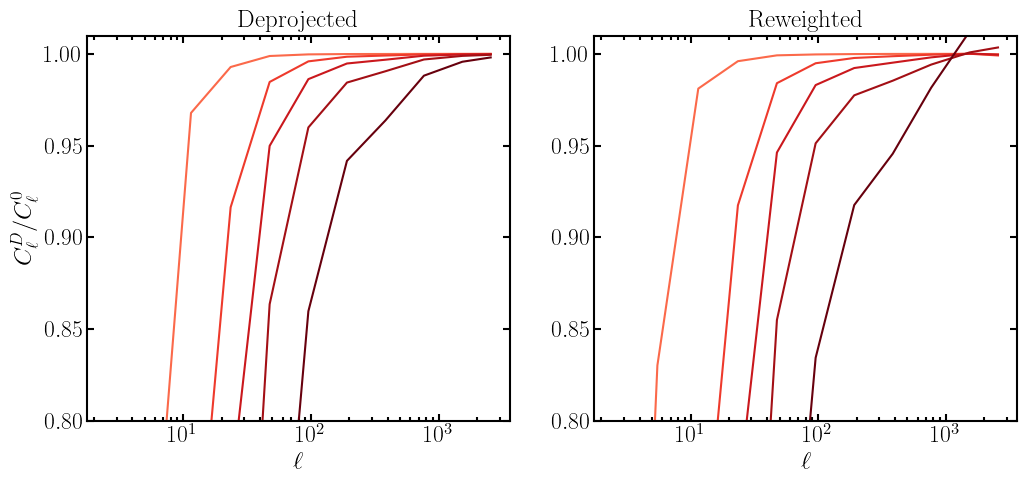

In [8]:
folder_list = ['1024_fiducial/', '1024_mp15/', '1024_high/', '1024_mp5/', '1024_m1/']
a_list = [-0.0287, -0.15, -0.287, -0.5, -1]
#folder_list = ['1024_high/']
#a_list = [-0.287]

nside = 1024
lmax = 3*nside+1

fig = plt.figure(figsize=(12,6))
fig_grid = fig.add_gridspec(1,2)
grid1 = fig_grid[0,0].subgridspec(3,1, hspace=0, height_ratios=[4,1,2])
axs = grid1.subplots()
grid2 = fig_grid[0,1].subgridspec(3,1, hspace=0, height_ratios=[4,1,2])
axs2 = grid2.subplots()

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

def plot_specs(ax, ylabel, xlabel, ells, ymin=None, ymax=None, yscale='log', xscale='log', fill_between=False, band=None, dell=None):
    ax.axhline(0,ls='--', color='grey')
    if fill_between==True:
        ax.fill_between(y1=-1, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
        ax.fill_between(y1=-3, y2=3, x=ells, alpha=0.3, color='grey', edgecolor=None)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlim(ells[0], ells[-1])
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if band:
        ax.axvspan(band*dell, (band+1)*dell, facecolor='grey', alpha=0.3)
    return

cmap = mpl.colormaps.get_cmap('Greens')(np.linspace(0.5,1,len(a_list)))
cmap_blues = mpl.colormaps.get_cmap('Blues')(np.linspace(0.5,1,len(a_list)))
cmap_reds = mpl.colormaps.get_cmap('Reds')(np.linspace(0.5,1,len(a_list)))

mean_bias_arr = []
for i, folder in enumerate(folder_list):
    path = f'/vol/aleph/data/mheld/salmo/SALMO_simulations/nonlinearbias/{folder}'

    cls = pd.read_csv(f'{path}ClsSALMO/mean_Cls.data')

    ells = cls['ell'].to_numpy()
    cls0_mean = cls['Cl_NoVD'].to_numpy()
    clsD_mean = cls['Cl_Deprojected'].to_numpy()
    cls1_mean = cls['Cl_VD'].to_numpy()
    cls0_unc = cls['Cl_NoVD unc'].to_numpy()
    clsD_unc = cls['Cl_Deprojected unc'].to_numpy()
    cls1_unc = cls['Cl_VD unc'].to_numpy()

    if folder == folder_list[0]:
        axs[0].plot(ells, cls0_mean, color='indianred', label='without VD')
        axs[0].fill_between(ells, cls0_mean- cls0_unc, cls0_mean+ cls0_unc, color='indianred', alpha=0.4)
    
    axs[0].plot(ells, clsD_mean, color=cmap[i], label=f'deprojected, $a={a_list[i]}$')
    axs[0].fill_between(ells, clsD_mean- clsD_unc, clsD_mean+ clsD_unc, color=cmap[i], alpha=0.4)
    #axs[0].plot(ells, cls_theo, color='black', linestyle=':', label='Theory Power Spectrum')
    
    axs[2].plot(ells, (cls0_mean - clsD_mean) / cls0_mean, color=cmap[i])
    axs[1].plot(ells, (cls0_mean - clsD_mean) / cls0_unc, color=cmap[i])
    #axs[1].plot(ells, (cls0_mean - cls1_mean) / cls0_mean, color=cmap_blues[i])
    #axs[2].plot(ells, (cls0_mean - cls1_mean) / cls0_unc, color=cmap_blues[i])
    
    #mean_bias = np.mean(devD[1:])
    #mean_bias_arr.append(mean_bias)

    cls_reweight = pd.read_csv(f'{path}ClsSALMO_reweight/mean_Cls.data')
    cls0_mean_reweight = cls_reweight['Cl_NoVD'].to_numpy()
    clsD_mean_reweight = cls_reweight['Cl_Deprojected'].to_numpy()
    cls1_mean_reweight = cls_reweight['Cl_VD'].to_numpy()
    cls0_unc_reweight = cls_reweight['Cl_NoVD unc'].to_numpy()
    clsD_unc_reweight = cls_reweight['Cl_Deprojected unc'].to_numpy()
    cls1_unc_reweight = cls_reweight['Cl_VD unc'].to_numpy()

    if folder == folder_list[0]:
        axs2[0].plot(ells, cls0_mean_reweight, color='indianred', label='without systematics')
        axs2[0].fill_between(ells, cls0_mean_reweight- cls0_unc_reweight, cls0_mean_reweight + cls0_unc_reweight, color='indianred', alpha=0.4)
    
    axs2[0].plot(ells, clsD_mean_reweight, color=cmap[i], label=f'deprojected, $a={a_list[i]}$')
    axs2[0].fill_between(ells, clsD_mean_reweight- clsD_unc_reweight, clsD_mean_reweight+ clsD_unc_reweight, color=cmap[i], alpha=0.4)
    #axs[0].plot(ells, cls_theo, color='black', linestyle=':', label='Theory Power Spectrum')


    #devD_reweight = (cls0_mean_reweight - clsD_mean_reweight) / cls0_unc_reweight
    axs2[2].plot(ells, (cls0_mean_reweight - clsD_mean_reweight) / cls0_mean_reweight, color=cmap[i])
    axs2[1].plot(ells, (cls0_mean_reweight - clsD_mean_reweight) / cls0_unc_reweight, color=cmap[i])
    #axs2[1].plot(ells, (cls0_mean_reweight - cls1_mean_reweight) / cls0_mean_reweight, color=cmap_blues[i])
    #axs2[2].plot(ells, (cls0_mean_reweight - cls1_mean_reweight) / cls0_unc_reweight, color=cmap_blues[i])
        
    ax2[0].plot(ells, clsD_mean / cls1_mean, color=cmap_reds[i])
    ax2[1].plot(ells, clsD_mean_reweight / cls1_mean_reweight, color=cmap_reds[i])
ax2[0].set_title('Deprojected')
ax2[1].set_title('Reweighted')
ax2[0].set_xscale('log')
ax2[0].set_xlabel('$\\ell$')
ax2[1].set_xscale('log')
ax2[1].set_xlabel('$\\ell$')
ax2[0].set_ylabel('$C_\\ell^{D} / C_\\ell^{0}$')
ax2[0].set_ylim(.8,1.01)
ax2[1].set_ylim(.8,1.01)

axs[0].legend(loc='lower left', frameon=False, fontsize=16.5)
plot_specs(axs[0], f'$C_\\ell$', None, ells, ymin=3e-8, ymax=1.1e-5, yscale='log', xscale='log', fill_between=False)
plot_specs(axs[2], '$\\frac{C_\\ell^{0} - C_\\ell^{D}}{C_\\ell^{0}}$', '$\\ell$', ells, ymin=-0.045, ymax=0.005, yscale='linear', xscale='log', fill_between=False)
plot_specs(axs[1], '$\\frac{C_\\ell^{0} - C_\\ell^{D}}{\\sigma_{C_\\ell^{0}}}$', '$\\ell$', ells, ymin=-4, ymax=4, yscale='linear', xscale='log', fill_between=True)
plot_specs(axs2[0], None, None, ells, ymin=3e-8, ymax=1.1e-5, yscale='log', xscale='log', fill_between=False)
plot_specs(axs2[2], None, '$\\ell$', ells, ymin=-0.045, ymax=0.005, yscale='linear', xscale='log', fill_between=False)
plot_specs(axs2[1], None, None, ells, ymin=-4, ymax=4, yscale='linear', xscale='log', fill_between=True)

fig.tight_layout()
fig.savefig('../figs_thesis/reweightingVSdeprojecting_full.png')
#fig2.savefig('reweightingVSdeprojecting_ratio.jpeg')
plt.show()

## Linear addition of the systematics

Look how everything looks if the systematics are added directly and not with salmo

Remember:

$$
\delta_{VD} (\vartheta) = \delta_{noVD}(\vartheta) (a\cdot s(\vartheta) + b) + a\cdot s(\vartheta) 
$$

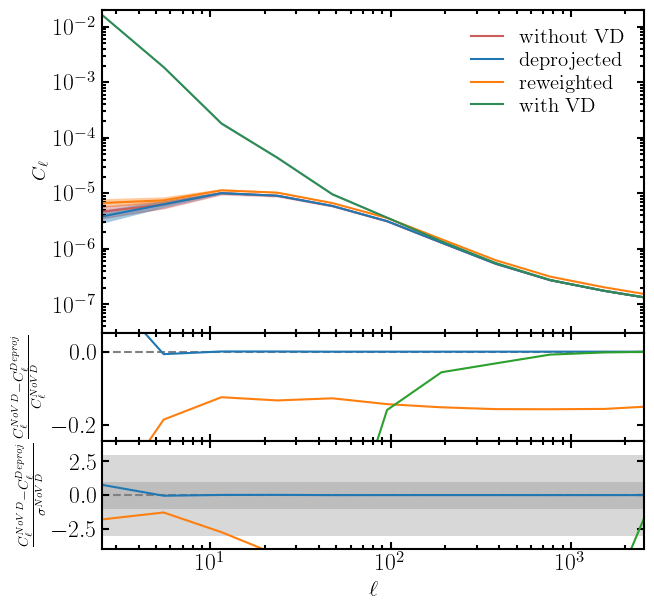

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,7), height_ratios=(3,1,1))
fig.subplots_adjust(hspace=0)


def plot_specs(ax, ylabel, xlabel, ells, ymin=None, ymax=None, yscale='log', xscale='log', fill_between=False, band=None, dell=None):
    ax.axhline(0,ls='--', color='grey', zorder=0)
    if fill_between==True:
        ax.fill_between(y1=-1, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
        ax.fill_between(y1=-3, y2=3, x=ells, alpha=0.3, color='grey', edgecolor=None)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlim(ells[0], ells[-1])
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if band:
        ax.axvspan(band*dell, (band+1)*dell, facecolor='grey', alpha=0.3)
    return


df = pd.read_csv('add_sys_directly.data')

#ells = df['ells'].to_numpy()
bedges = np.array([   2,    4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048, 3*nside])
bins = nmt.NmtBin.from_edges(bedges[:-1], bedges[1:])
ells = bins.get_effective_ells()

cls0 = df['cls0'].to_numpy()
cls1 = df['cls1'].to_numpy()
cls_dep = df['cls_dep'].to_numpy()
cls_rew = df['cls_rew'].to_numpy()
cls0_unc = df['cls0 unc'].to_numpy()
cls1_unc = df['cls1 unc'].to_numpy()
cls_dep_unc = df['cls_dep unc'].to_numpy()
cls_rew_unc = df['cls_rew unc'].to_numpy()


axs[0].plot(ells, cls0, color='indianred', label='without VD')
axs[0].fill_between(ells, cls0 - cls0_unc, cls0 + cls0_unc, color='indianred', alpha=0.4)
axs[0].plot(ells, cls_dep, label=f'deprojected')
axs[0].fill_between(ells, cls_dep- cls_dep_unc, cls_dep+ cls_dep_unc, alpha=0.4)
axs[0].plot(ells, cls_rew, label=f'reweighted')
axs[0].fill_between(ells, cls_rew- cls_rew_unc, cls_rew+ cls_rew_unc, alpha=0.4)
axs[0].plot(ells, cls1, label=f'with VD', color='seagreen')
axs[0].fill_between(ells, cls1- cls1_unc, cls1 + cls1_unc, alpha=0.4, color='seagreen')


axs[1].plot(ells, (cls0 - cls_dep) / cls0)
axs[1].plot(ells, (cls0 - cls_rew) / cls0)
axs[1].plot(ells, (cls0 - cls1) / cls0)

axs[2].plot(ells, (cls0 - cls_dep) / cls0_unc)
axs[2].plot(ells, (cls0 - cls_rew) / cls0_unc)
axs[2].plot(ells, (cls0 - cls1) / cls0_unc)



axs[0].legend(loc='upper right', frameon=False)
plot_specs(axs[0], f'$C_\\ell$', None, ells, ymin=3e-8, ymax=2e-2, yscale='log', xscale='log', fill_between=False)
plot_specs(axs[1], '$\\frac{C_\\ell^{No VD} - C_\\ell^{Deproj}}{C_\\ell^{No VD}}$', None, ells, ymin=-0.245, ymax=0.05, yscale='linear', xscale='log', fill_between=False)
plot_specs(axs[2], '$\\frac{C_\\ell^{No VD} - C_\\ell^{Deproj}}{\\sigma^{No VD}}$', '$\\ell$', ells, ymin=-4, ymax=4, yscale='linear', xscale='log', fill_between=True)
#axs[1].set_yticks([0,-0.02, -0.04])

plt.show()

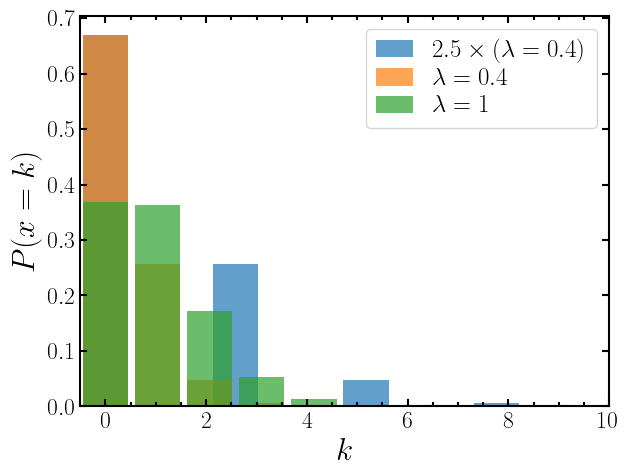

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

lam1 = 0.4
lam2 = 1

xmax = 30
t = np.linspace(0, xmax, xmax)
d1 = np.exp(-lam1)*lam1**t/factorial(t)
d10 = np.exp(-lam2)*lam2**t/factorial(t)

binwidth = (t[1]-t[0]) * lam2/lam1

#plt.title('Poisson distribution for different $\\lambda$ before and after reweighting')
plt.bar(t*lam2/lam1, d1, label=f'${round(lam2/lam1, 2)}\\times(\\lambda={lam1})$', width=0.9, alpha=0.7)
plt.bar(t, d1, label=f'$\\lambda={lam1}$', alpha=0.7, width=0.9)
plt.bar(t, d10, label=f'$\\lambda={lam2}$', alpha=0.7, width=0.9)
plt.xlabel('$k$', fontsize=23)
plt.ylabel('$P(x=k)$', fontsize=23)
plt.xlim(-0.5,10)
plt.ylim(ymin=0)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig(f'../figs_thesis/poisson_{lam1}_{lam2}.png')
plt.show()

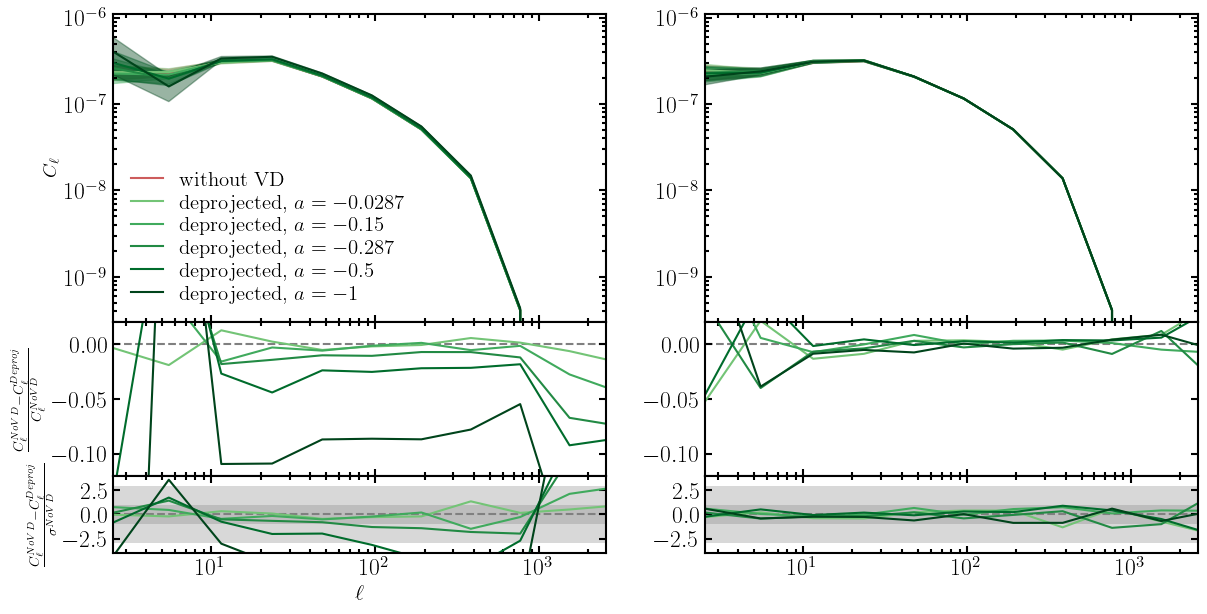

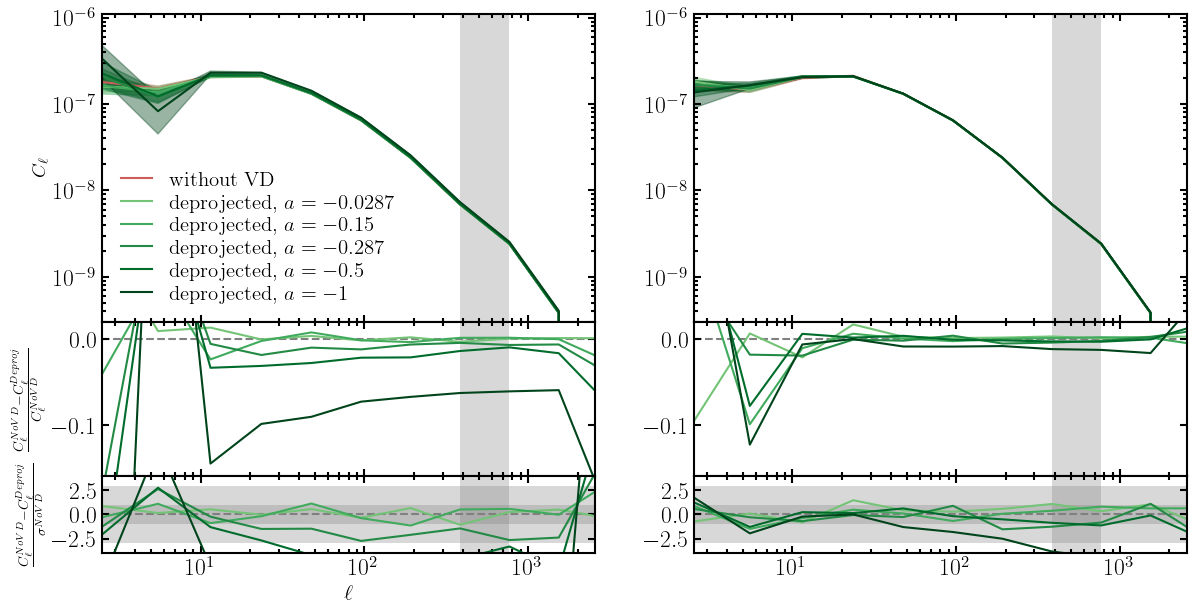

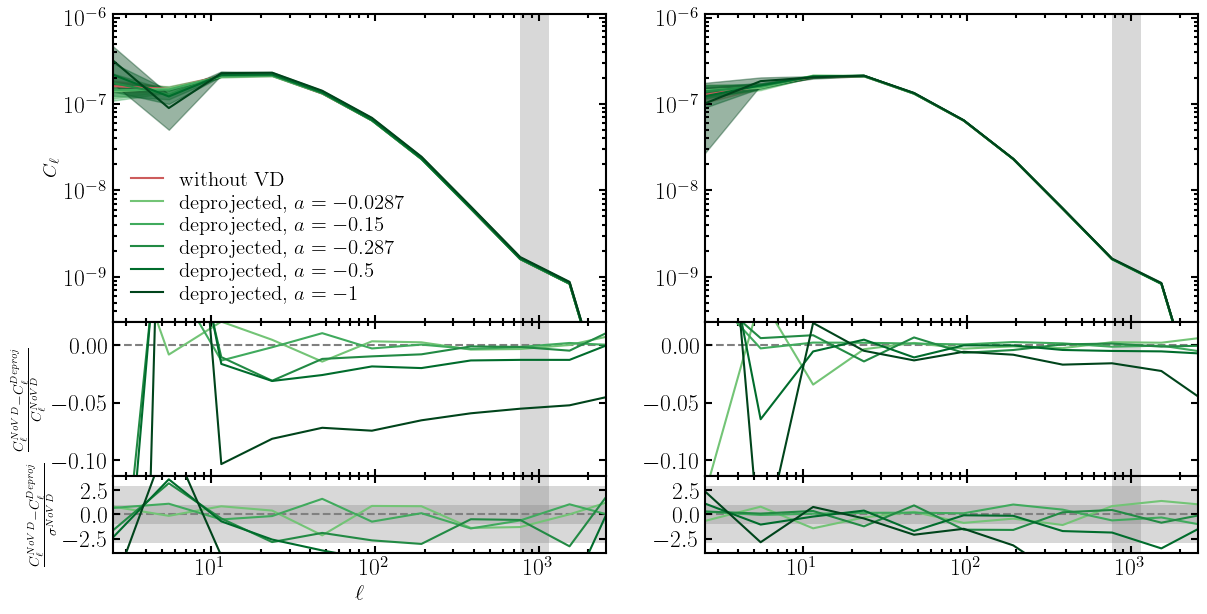

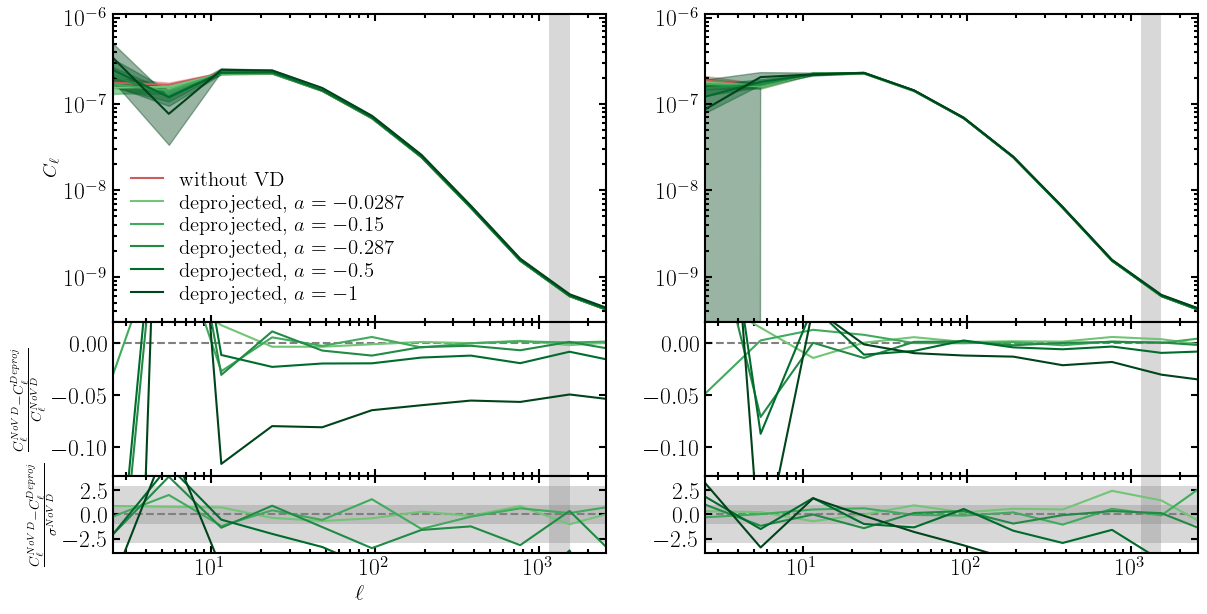

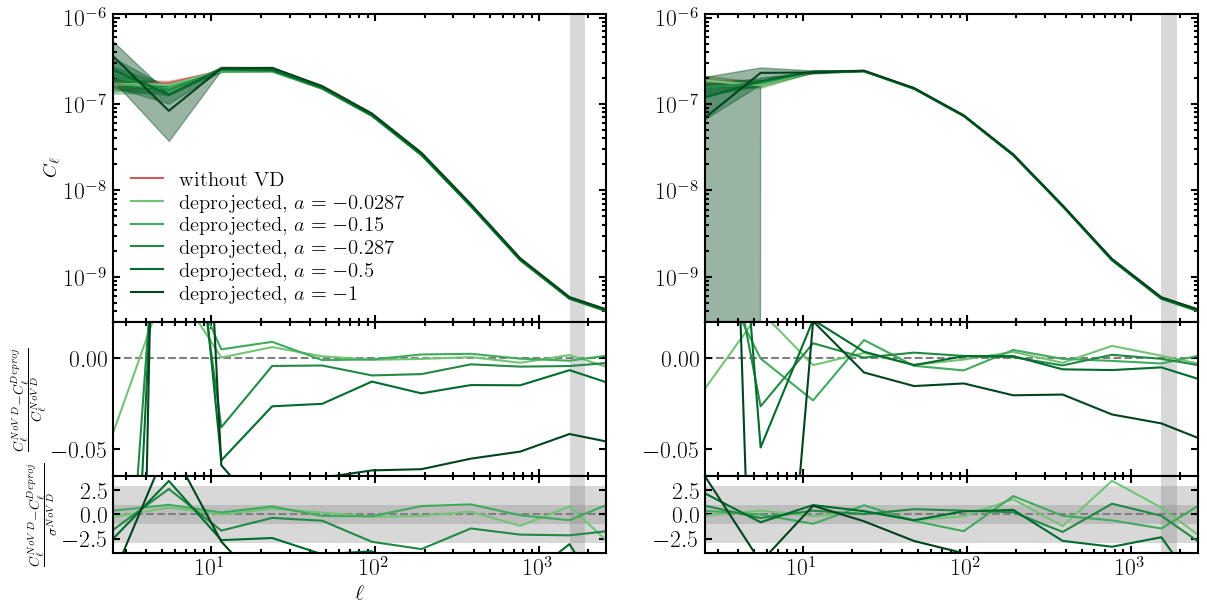

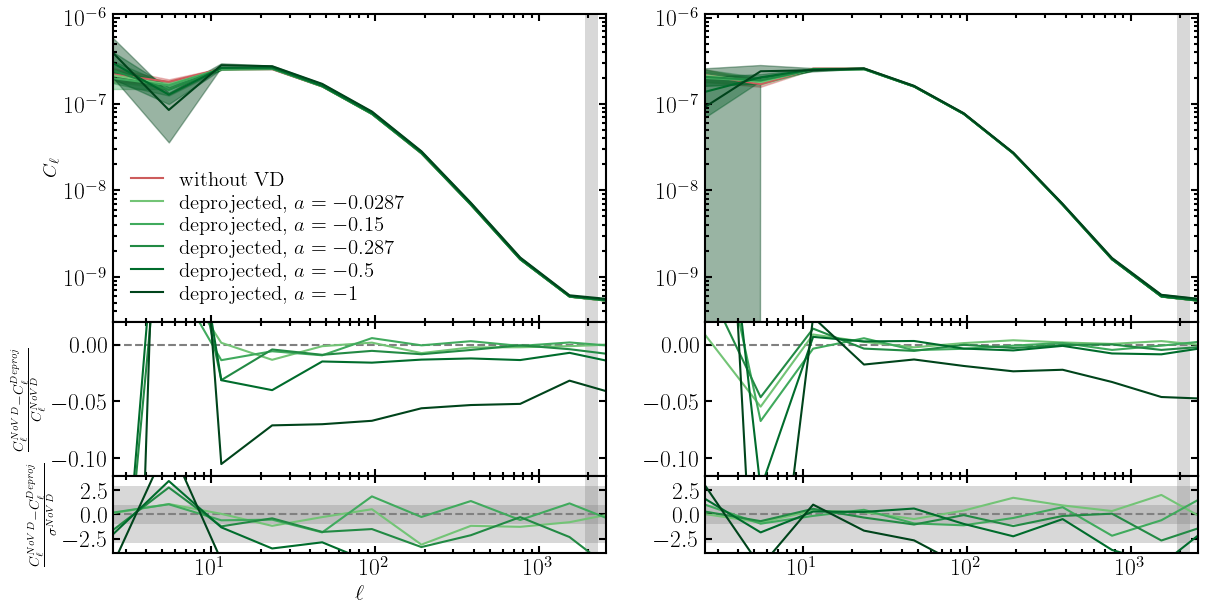

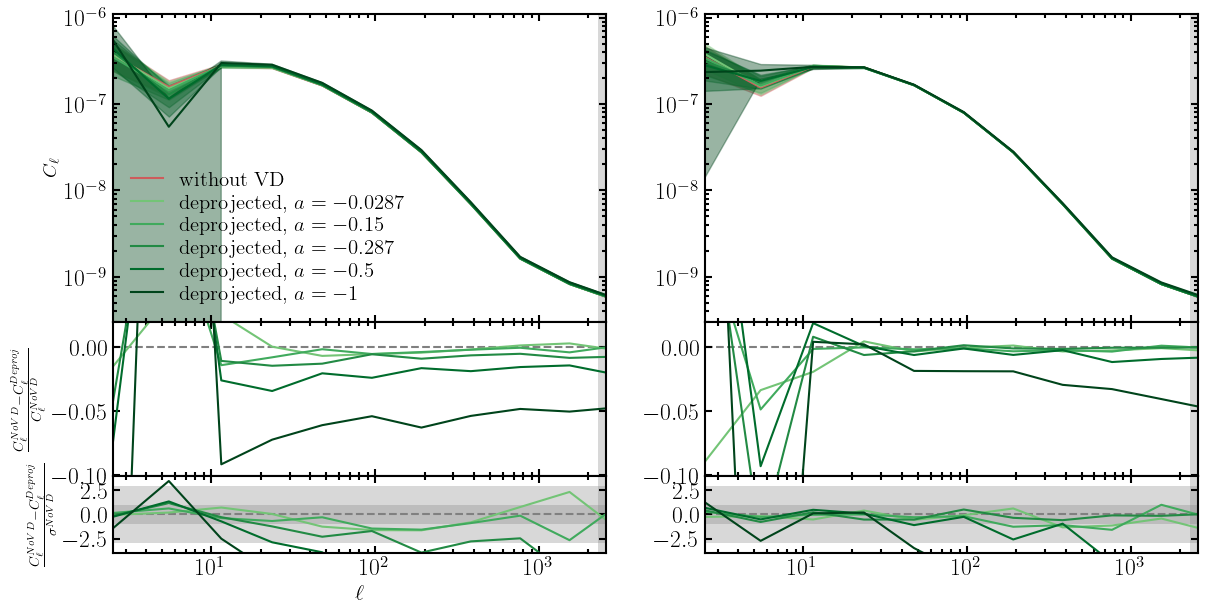

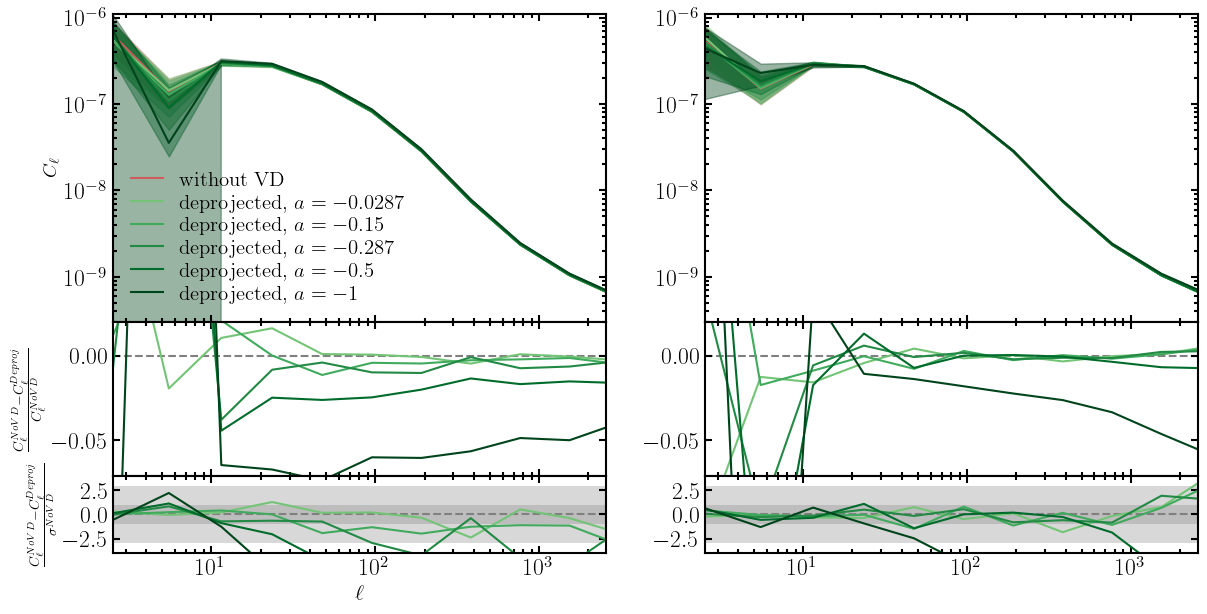

In [7]:
folder_list = ['1024_fiducial/', '1024_mp15/', '1024_high/', '1024_mp5/', '1024_m1/']
a_list = [-0.0287, -0.15, -0.287, -0.5, -1]
#folder_list = ['1024_high/']
#a_list = [-0.287]

nside = 1024
lmax = 3*nside+1
nbands = 8
dell = lmax // nbands




cmap = mpl.colormaps.get_cmap('Greens')(np.linspace(0.5,1,len(a_list)))
mean_bias_arr = []
for j in range(nbands):
    fig = plt.figure(figsize=(14,7))
    fig_grid = fig.add_gridspec(1,2)
    grid1 = fig_grid[0,0].subgridspec(3,1, hspace=0, height_ratios=[4,2,1])
    axs = grid1.subplots()
    grid2 = fig_grid[0,1].subgridspec(3,1, hspace=0, height_ratios=[4,2,1])
    axs2 = grid2.subplots()
    for i, folder in enumerate(folder_list):
        path = f'/vol/aleph/data/mheld/salmo/SALMO_simulations/nonlinearbias/{folder}'

        fsb = pd.read_csv(f'{path}FsbSALMO/mean_FSB.data')

        ells = fsb['ell'].to_numpy()
        fsb0_mean = fsb[f'FSB_NoVD_bin{j}'].to_numpy()
        fsbD_mean = fsb[f'FSB_Deprojected_bin{j}'].to_numpy()
        fsb0_unc = fsb[f'FSB_NoVD_bin{j} unc'].to_numpy()
        fsbD_unc = fsb[f'FSB_Deprojected_bin{j} unc'].to_numpy()

        if folder == folder_list[0]:
            axs[0].plot(ells, fsb0_mean, color='indianred', label='without VD')
            axs[0].fill_between(ells, fsb0_mean- fsb0_unc, fsb0_mean+ fsb0_unc, color='indianred', alpha=0.4)
        
        axs[0].plot(ells, fsbD_mean, label=f'deprojected, $a={a_list[i]}$', color=cmap[i])
        axs[0].fill_between(ells, fsbD_mean- fsbD_unc, fsbD_mean+ fsbD_unc, alpha=0.4, color=cmap[i])
        #axs[0].plot(ells, cls_theo, color='black', linestyle=':', label='Theory Power Spectrum')
        
        rel = (fsb0_mean - fsbD_mean) / fsb0_mean
        sig = (fsb0_mean - fsbD_mean) / fsb0_unc

        axs[1].plot(ells, rel, color=cmap[i])
        axs[2].plot(ells, sig, color=cmap[i])
        
        #mean_bias = np.mean(devD[1:])
        #mean_bias_arr.append(mean_bias)

        fsb_reweight = pd.read_csv(f'{path}FsbSALMO_reweight/mean_FSB.data')
        fsb0_mean_reweight = fsb_reweight[f'FSB_NoVD_bin{j}'].to_numpy()
        fsbD_mean_reweight = fsb_reweight[f'FSB_Deprojected_bin{j}'].to_numpy()
        fsb0_unc_reweight = fsb_reweight[f'FSB_NoVD_bin{j} unc'].to_numpy()
        fsbD_unc_reweight = fsb_reweight[f'FSB_Deprojected_bin{j} unc'].to_numpy()
        #print(fsbD_mean_reweight)
        if folder == folder_list[0]:
            axs2[0].plot(ells, fsb0_mean_reweight, color='indianred', label='without VD')
            axs2[0].fill_between(ells, fsb0_mean_reweight- fsb0_unc_reweight, fsb0_mean_reweight + fsb0_unc_reweight, color='indianred', alpha=0.4)
        
        axs2[0].plot(ells, fsbD_mean_reweight, color=cmap[i], label=f'deprojected, $a={a_list[i]}$')
        axs2[0].fill_between(ells, fsbD_mean_reweight- fsbD_unc_reweight, fsbD_mean_reweight+ fsbD_unc_reweight, color=cmap[i], alpha=0.4)
        #axs[0].plot(ells, cls_theo, color='black', linestyle=':', label='Theory Power Spectrum')


        rel_reweight = (fsb0_mean_reweight - fsbD_mean_reweight) / fsb0_mean_reweight
        sig_reweight = (fsb0_mean_reweight - fsbD_mean_reweight) / fsb0_unc_reweight
        axs2[1].plot(ells, rel_reweight, color=cmap[i])
        axs2[2].plot(ells, sig_reweight, color=cmap[i])
            
            

    axs[0].legend(loc='lower left', frameon=False)
    plot_specs(axs[0], f'$C_\\ell$', None, ells, ymin=3e-10, ymax=1.1e-6, yscale='log', xscale='log', fill_between=False, band=j, dell=dell)
    plot_specs(axs[1], '$\\frac{C_\\ell^{No VD} - C_\\ell^{Deproj}}{C_\\ell^{No VD}}$', None, ells, ymin=1.1*rel[2], ymax=0.02, yscale='linear', xscale='log', fill_between=False, band=j, dell=dell)
    plot_specs(axs[2], '$\\frac{C_\\ell^{No VD} - C_\\ell^{Deproj}}{\\sigma^{No VD}}$', '$\\ell$', ells, ymin=-4, ymax=4, yscale='linear', xscale='log', fill_between=True, band=j, dell=dell)
    plot_specs(axs2[0], None, None, ells, ymin=3e-10, ymax=1.1e-6, yscale='log', xscale='log', fill_between=False, band=j, dell=dell)
    plot_specs(axs2[1], None, None, ells, ymin=1.1*rel[2], ymax=0.02, yscale='linear', xscale='log', fill_between=False, band=j, dell=dell)
    plot_specs(axs2[2], None, None, ells, ymin=-4, ymax=4, yscale='linear', xscale='log', fill_between=True, band=j, dell=dell)


    plt.show()

### Deprojecting the simulations

Does the deprojection work properly for both methods?

To investigate this, I plot the relationship between the template values and the ngal values of the contaminated maps and then also of the reweighted/deprojected maps.

After removing the systematics the relation should be equal to 0.

The calculation of the relationship is done in check_ngalrel.py and the results are plotted here.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
a_list = [-0.15, -0.287, -0.5, -1]

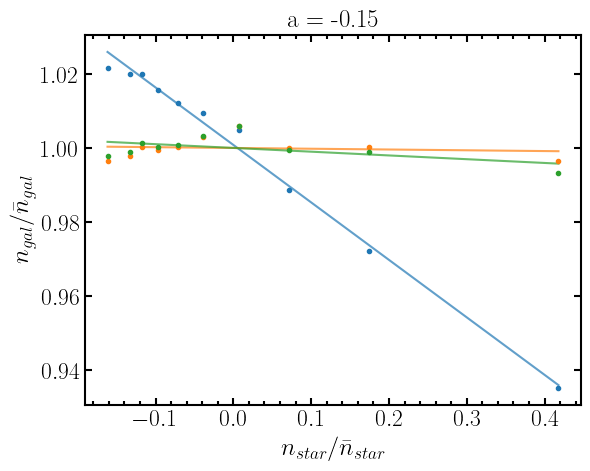

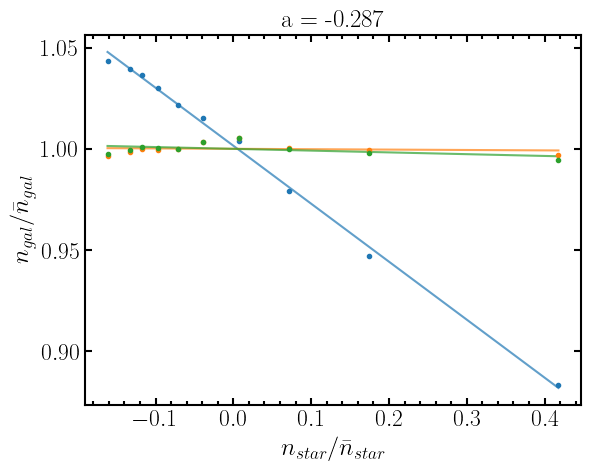

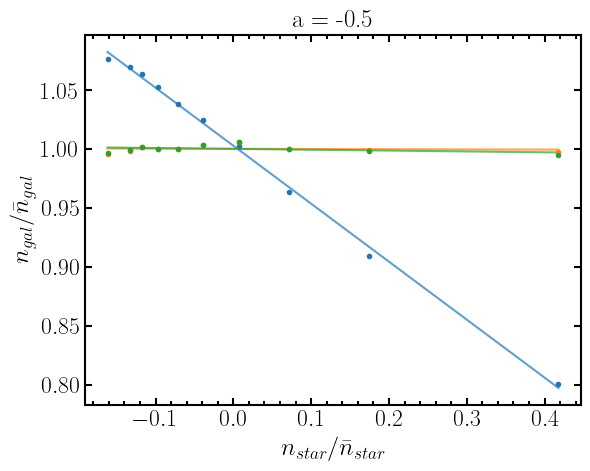

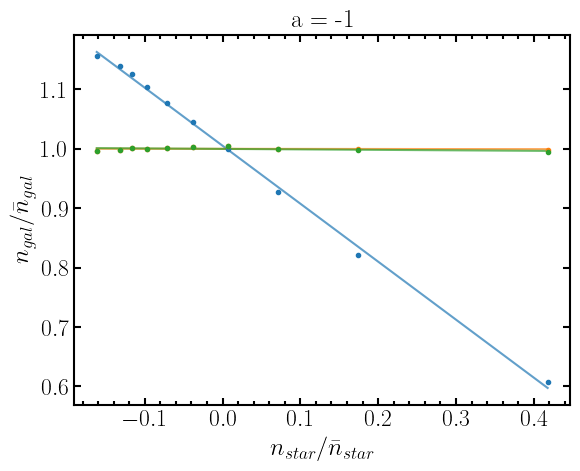

In [9]:
sysrel_df = pd.read_csv('nstarVSngal_sims.data')
pars = pd.read_csv('nstarVSngal_fitparams.data')
def linear(x, a, b):
    return a*x+b

for a in a_list:
    fig = plt.figure()  


    plt.errorbar(sysrel_df[f'stars'], sysrel_df[f'with VD: {a}'],  marker='.', linestyle='', label='with VD', color='tab:blue')
    plt.plot(sysrel_df[f'stars'], linear(sysrel_df[f'stars'].to_numpy(), pars[f"with VD: {a}, a"].to_numpy(), pars[f"with VD: {a}, b"].to_numpy()), color='tab:blue', alpha=0.7)
    
    plt.errorbar(sysrel_df[f'stars'], sysrel_df[f'mode deprojection: {a}'],  marker='.', linestyle='', label='mode deprojection', color='tab:orange')
    plt.plot(sysrel_df[f'stars'], linear(sysrel_df[f'stars'].to_numpy(), pars[f'mode deprojection: {a}, a'].to_numpy(), pars[f'mode deprojection: {a}, b'].to_numpy()), color='tab:orange', alpha=0.7)
    
    plt.errorbar(sysrel_df[f'stars'], sysrel_df[f'DES Y1 method: {a}'],  marker='.', linestyle='', label='DES-Y1 method', color='tab:green')
    plt.plot(sysrel_df[f'stars'], linear(sysrel_df[f'stars'].to_numpy(), pars[f'DES Y1 method: {a}, a'].to_numpy(), pars[f'DES Y1 method: {a}, b'].to_numpy()), color='tab:green', alpha=0.7) 

    plt.title(f'a = {a}')
    #plt.plot(sysrel_df[f'stars'], n_gals_reweight, label='DES-Y1 method')
    plt.xlabel('$n_{star} / \\bar{n}_{star}$')
    plt.ylabel('$n_{gal} / \\bar{n}_{gal}$')
    
    plt.savefig(f'./ngal_rel_{-a*1000}.png')    
    plt.show()

### Mitigated maps

Now, let us look at the deprojected/reweighted maps. Something has to explain the offset on small scales that is visible in the power spectrum and also in the FSB. An explanation might be, that in the reweighting some small structures may get erased.


First, plot the three maps:

In [9]:
maps = pd.read_csv('maps.data')

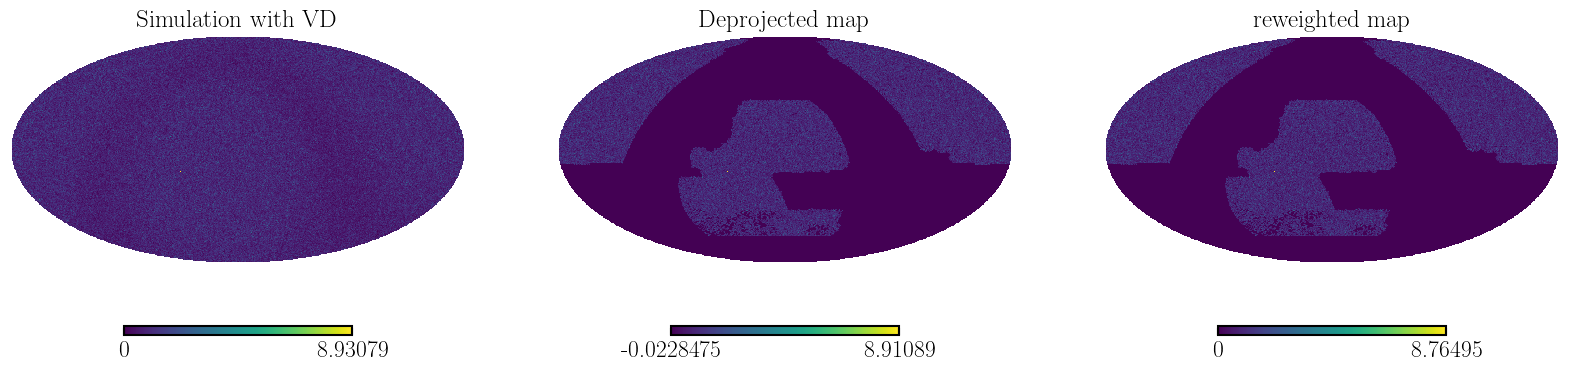

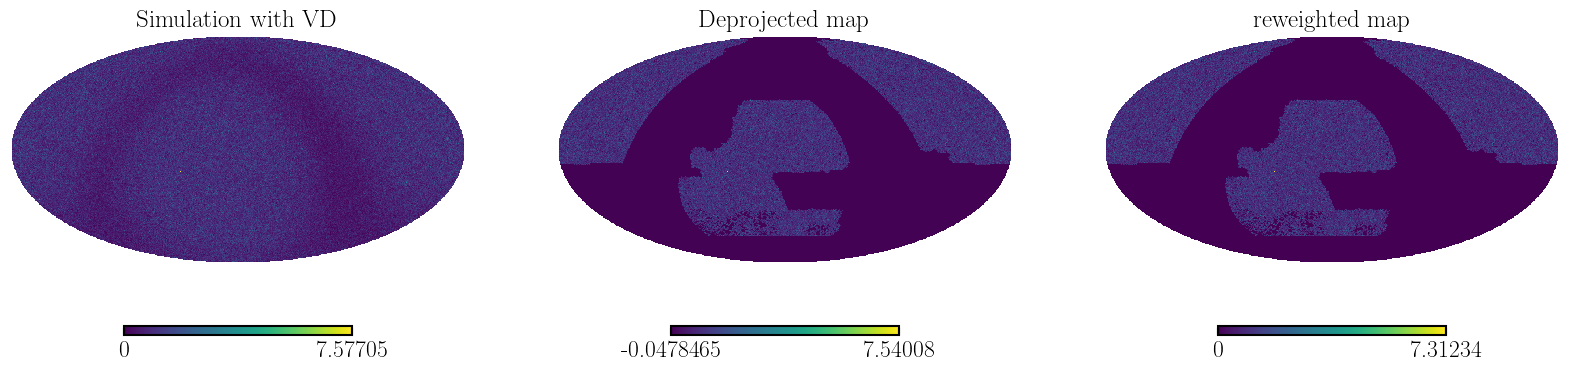

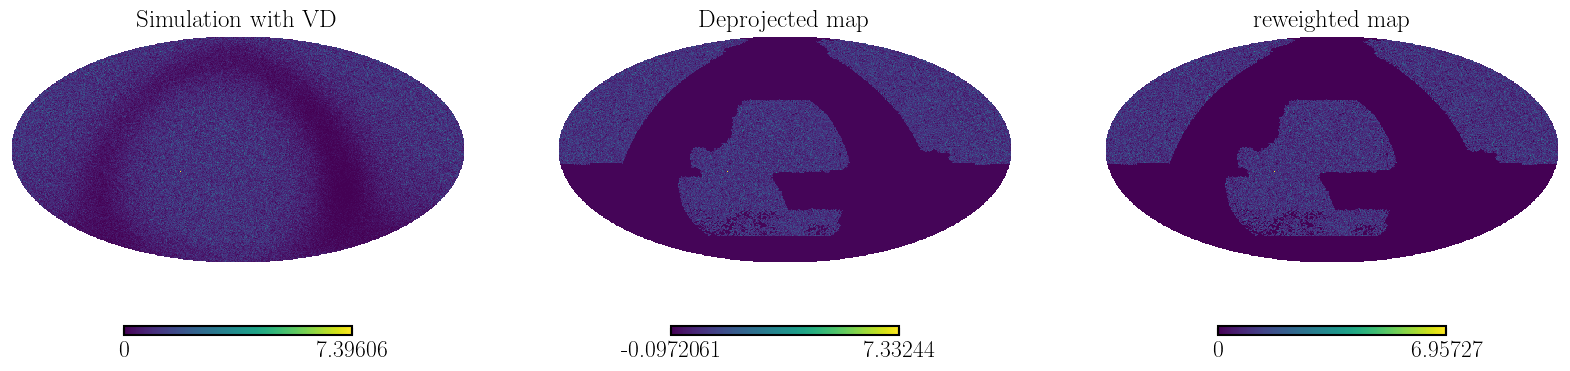

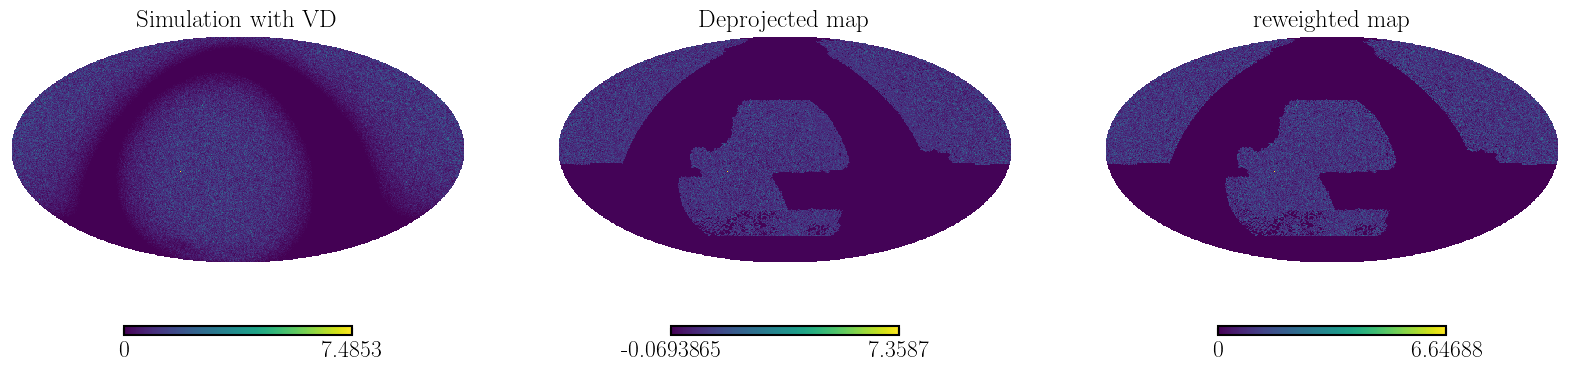

In [11]:
for a in a_list:
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20,16))
    axs = axs.flatten()
    plt.axes(axs[0])
    hp.mollview(maps[f'Sim with VD: {a}'], title='Simulation with VD', hold=True)
    plt.axes(axs[1])
    hp.mollview(maps[f'Deprojected map: {a}'], title='Deprojected map', hold=True)
    plt.axes(axs[2])
    hp.mollview(maps[f'Reweighted map: {a}'], title='reweighted map', hold=True)
    plt.show()

I cannot really see any specific structures that get erased. But, removing the systematics by reweighting the map produces a clean map, where the maximum number density is lower than for the deprojected map. This discrepancy gets bigger for more extreme systematics (i.e. for larger absolute value of a)

To test this further, I plot the histogram of the deprojected and the reweighted maps:

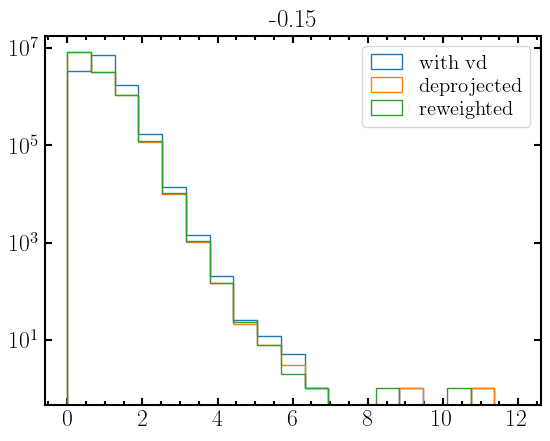

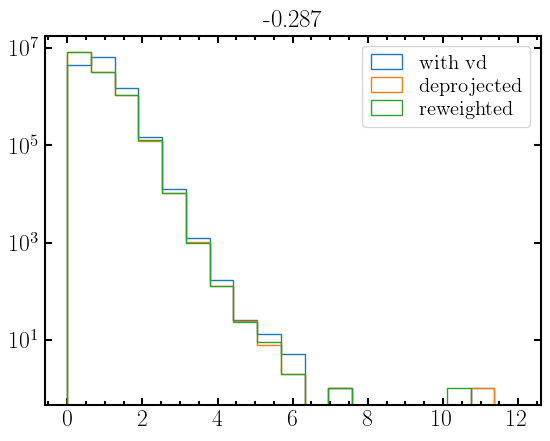

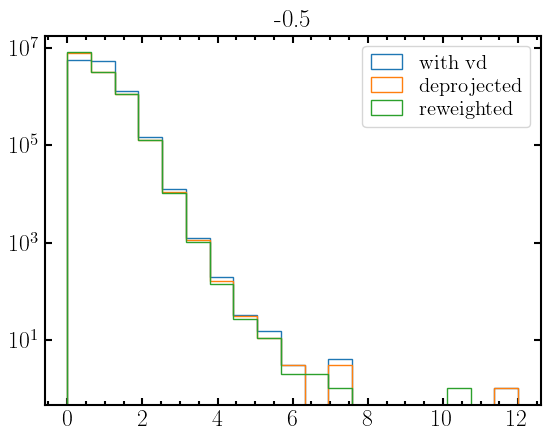

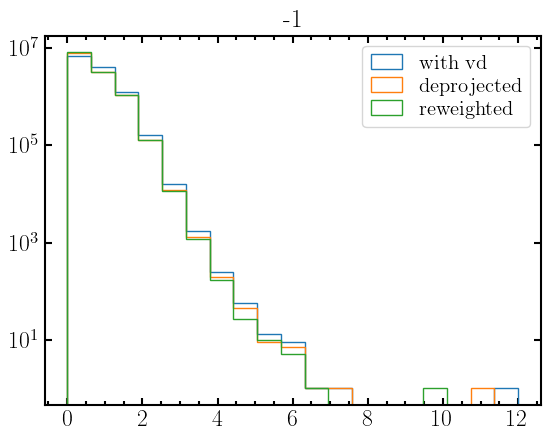

In [12]:
b = np.linspace(0,12,20)
for a in a_list:
    plt.title(a)
    plt.hist(maps[f'Sim with VD: {a}'], bins=b, label='with vd', histtype='step')
    plt.hist(maps[f'Deprojected map: {a}'], bins=b, label='deprojected', histtype='step')
    plt.hist(maps[f'Reweighted map: {a}'], bins=b, label='reweighted', histtype='step')
    plt.legend()
    plt.yscale('log')
    plt.show()

A big difference between the methods is not visible. They only differ for larger values of ngal.

Now: look at the ratio of the deprojected and reweighted maps. This shows where the two methods produce the biggest differences.

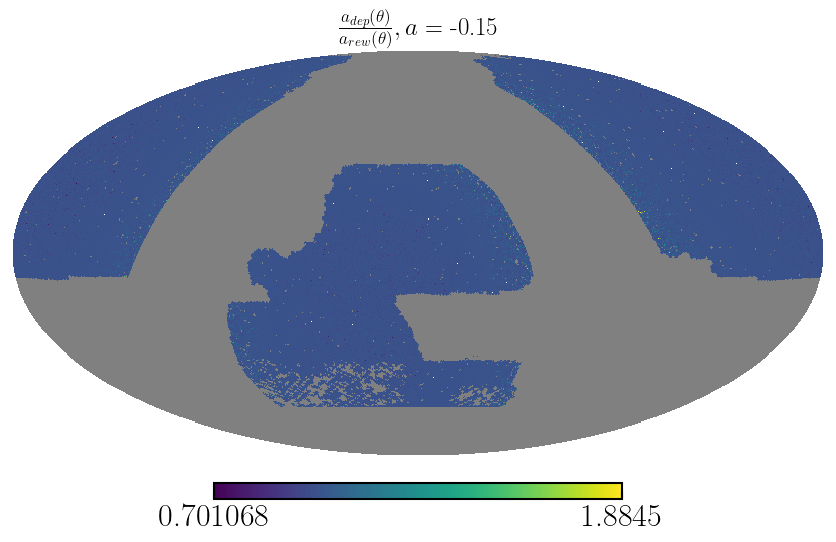

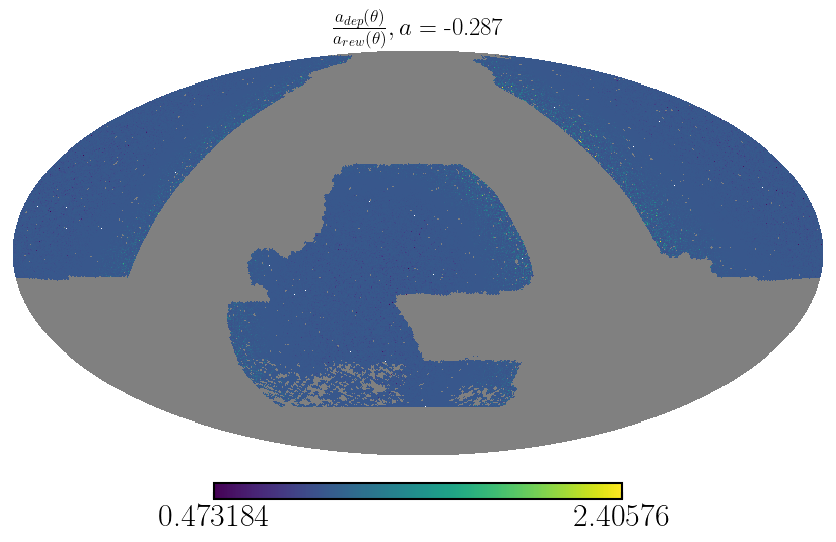

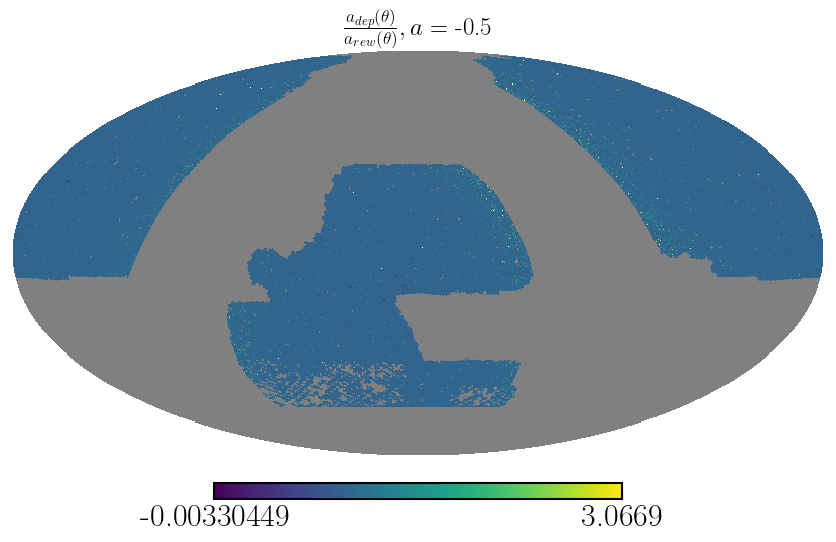

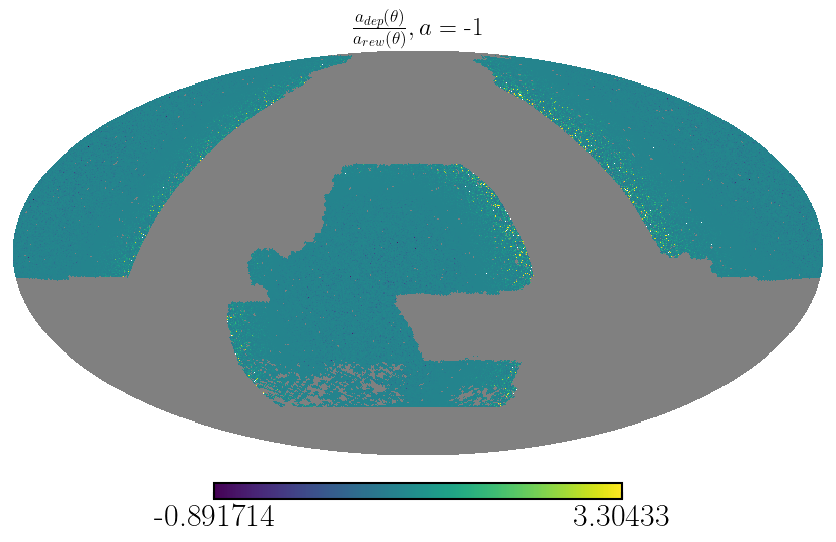

In [23]:
import matplotlib

matplotlib.rcParams.update({'font.size':18})

for a in a_list:
    hp.mollview(maps[f'Deprojected map: {a}']/maps[f'Reweighted map: {a}'], title='$\\frac{a_{dep}(\\theta)}{a_{rew}(\\theta)}, a =$ ' + str(a))
    fig = plt.gcf()  # Get current figure
    cbar = fig.axes[-1]  # The last axis is usually the colorbar
    cbar.tick_params(labelsize=23)  # Set the fontsize of colorbar ticks
    
    fig = plt.gcf()
    for ax in fig.axes:
        for txt in ax.texts:
            if 'a' in txt.get_text():
                txt.set_fontsize(100)  # Set your desired fontsize here

    #if a in [-0.15, -1]:
    #    plt.savefig(f'../figs_thesis/map_ratio_{a}.png')
    plt.show()

For more extreme a, there are (individual) pixels/regions where the two methods produce vastly different values of the mitigated maps. This ratio gets more extreme for larger absolute values of a.

These variations are very small, thus would show up on small scales in the power spectrum. This might explain the behaviour seen in the power spectrum plots: only on small scales a variation is visible and it gets more severe for more extreme a's. This is consistent with the plots. It also explains why this deviation is not seen (as extremely) in the FSB. For the first few bins of the FSB, no offset is visible, since all small scales are filtered out and thus all the variation of the maps is filtered out. Only in the filter regions, where just the smaller scales are not filtered out, an offset shows up.

Now, look at the histogram of the simulation/mitigated map:

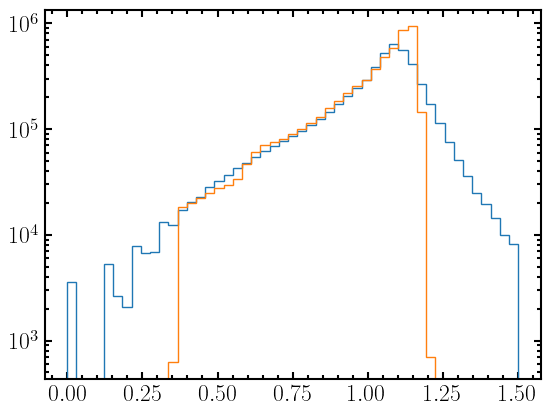

In [14]:
a = -1
plt.hist(maps[f'Sim with VD: {a}']/maps[f'Deprojected map: {a}'], bins=np.linspace(0,1.5), histtype='step')
plt.hist(maps[f'Sim with VD: {a}']/maps[f'Reweighted map: {a}'], bins=np.linspace(0,1.5), histtype='step')
#plt.hist(maps[f'Sim with VD: {a}']/copy_dep, bins=np.linspace(0,1.5), histtype='step')
plt.yscale('log')

Huge deviation:

The simulation/reweighted map is by definition $a/b\cdot s + 1$ where $s$ is the variable depth map since $m_{rew} = \frac{m_{sim}}{a/b\cdot s+1}$. 

For the deprojection case: broader distribution than for the reweighting 

I think that the pixels with more extreme ratio in the plots above correspond to the values in the histogram with ngal > 1.2 and ngal < 0.3.

In [15]:
path = f'/vol/aleph/data/mheld/salmo/SALMO_simulations/nonlinearbias/{folder}'
galmap = CreateGalaxyNumberDensityMap(f'{path}Catalogues/galCat_1_run2_type0.fits', mask, nside)


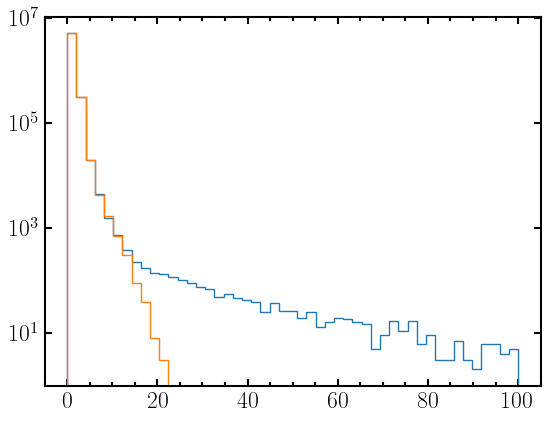

In [16]:
a = -0.5
plt.hist(galmap/maps[f'Deprojected map: {a}'], bins=np.linspace(0,100), histtype='step')
plt.hist(galmap/maps[f'Reweighted map: {a}'], bins=np.linspace(0,100), histtype='step')
#plt.hist(maps[f'Sim with VD: {a}']/copy_dep, bins=np.linspace(0,1.5), histtype='step')
plt.yscale('log')